# Rolling Planning mit Tardiness (Max)

In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.lp import tardiness_scheduling as lp_tard_schedule
from src.models.lp import tardiness_rescheduling as lp_tard_reschedule
import src.models.heuristics.fcfs as fcfs

# Simulation
from src.simulation.ProductionDaySimulation import ProductionDaySimulation

# Extern
import pandas as pd
pd.set_option('display.min_rows', 16)
pd.set_option('display.max_rows', 21)

In [2]:
max_time = 60*10 # 10 min

## Generierung des Datensatzes für 12 Tage (Ankunft)

In [3]:
day_count = 12

In [4]:
basic_data_path = get_path("data", "basic")
df_instance = pd.read_csv(basic_data_path / "instance.csv")

df_jssp, df_job_arrivals = init.create_production_orders_for_shifts(df_template=df_instance, shift_count=day_count,
                                                                 shift_length=1440, shuffle=True, 
                                                                 job_seed=40, arrival_seed=80)

df_job_times = gen_deadline.get_times_df(df_jssp, df_job_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_job_times


Schedule-Informationen:
  Makespan: 18248


,Job,Production_Plan_ID,Arrival,Deadline
0,0,0,51,1957.0
1,1,1,136,2597.0
2,2,2,158,2899.0
3,3,3,236,3397.0
4,4,4,404,2301.0
5,5,5,485,2879.0
6,6,6,501,2509.0
7,7,7,528,3129.0
...,...,...,...,...
237,237,4,16725,18622.0


## Params

In [5]:
# fix
day_length = 1440

In [6]:
# init
day_numb = 0

day_start = 0
day_end = 0

# Initialisierung (Tag 0)

In [7]:
day_numb = 0

In [8]:
day_start = day_length*day_numb                      # 0
day_end = day_start + day_length                     # 1440

In [9]:
# I)
df_jssp_curr, df_times_curr = process_filter.jobs_by_arrival_window(df_job_times, df_jssp, day_start, day_end)
df_jssp_curr

,Job,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,0,M00,29
1,0,0,1,M01,78
2,0,0,2,M02,9
3,0,0,3,M03,36
4,0,0,4,M04,49
5,0,0,5,M05,11
6,0,0,6,M06,62
7,0,0,7,M07,56
...,...,...,...,...,...
172,17,3,2,M00,71


In [10]:
df_times_curr 

,Job,Production_Plan_ID,Arrival,Deadline
0,0,0,51,1957.0
1,1,1,136,2597.0
2,2,2,158,2899.0
3,3,3,236,3397.0
4,4,4,404,2301.0
5,5,5,485,2879.0
6,6,6,501,2509.0
7,7,7,528,3129.0
8,8,8,550,3431.0
9,9,9,559,3165.0


### Scheduling

In [11]:
# Scheduling
df_schedule = lp_tard_schedule.solve_jssp_sum(df_jssp_curr, df_times_curr, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.01)
df_schedule

BigM: 8000

Solver-Informationen:
  Summe Tardiness         : 0.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1746
  Anzahl Constraints      : 3258
  Laufzeit                : ~1 Sekunden


,Job,Production_Plan_ID,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,0,0,0,51,1957.0,M00,51.0,29.0,80.0,0
1,0,0,1,51,1957.0,M01,80.0,78.0,158.0,0
2,0,0,2,51,1957.0,M02,158.0,9.0,167.0,0
3,0,0,3,51,1957.0,M03,167.0,36.0,203.0,0
4,0,0,4,51,1957.0,M04,203.0,49.0,252.0,0
5,0,0,5,51,1957.0,M05,252.0,11.0,263.0,0
6,0,0,6,51,1957.0,M06,263.0,62.0,325.0,0
7,0,0,7,51,1957.0,M07,325.0,56.0,381.0,0
...,...,...,...,...,...,...,...,...,...,...
172,12,8,9,992,3873.0,M08,3727.0,74.0,3801.0,0


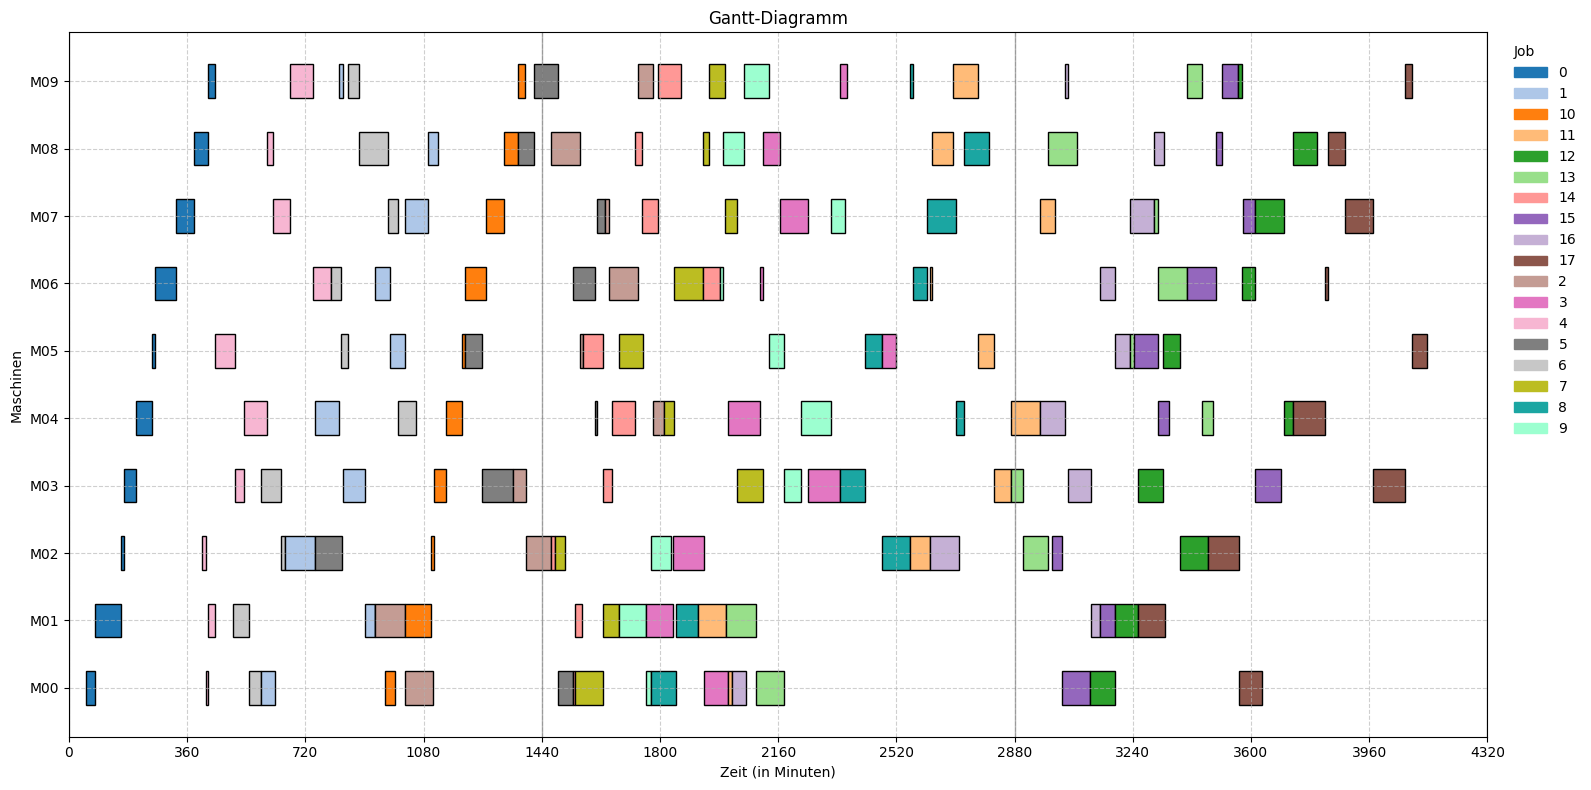

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [12]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

In [13]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
print(show.count_column_grouped(last_ops, 'Tardiness'))

label
0            18
0 - 60        0
60 - 120      0
120 - 180     0
>180          0
Name: count, dtype: int64


### Simulation

In [14]:
simulation = ProductionDaySimulation(df_schedule, vc=0.35)
df_execution = simulation.run(start_time = day_start, end_time=day_end)

[00:51:00] Job 0 started on M00
[01:17:53] Job 0 finished on M00 (after 26 minutes 53 seconds)
[01:20:00] Job 0 started on M01
[01:59:24] Job 0 finished on M01 (after 39 minutes 24 seconds)
[02:38:00] Job 0 started on M02
[02:50:10] Job 0 finished on M02 (after 12 minutes 10 seconds)
[02:50:10] Job 0 started on M03
[03:18:46] Job 0 finished on M03 (after 28 minutes 37 seconds)
[03:23:00] Job 0 started on M04
[03:54:57] Job 0 finished on M04 (after 31 minutes 58 seconds)
[04:12:00] Job 0 started on M05
[04:21:55] Job 0 finished on M05 (after 09 minutes 56 seconds)
[04:23:00] Job 0 started on M06
[05:03:26] Job 0 finished on M06 (after 40 minutes 26 seconds)
[05:25:00] Job 0 started on M07
[06:44:00] Job 4 started on M02
[07:03:05] Job 4 finished on M02 (after 19 minutes 05 seconds)
[07:03:05] Job 4 started on M00
[07:09:37] Job 4 finished on M00 (after 06 minutes 32 seconds)
[07:09:37] Job 4 started on M01
[07:15:33] Job 0 finished on M07 (after 110 minutes 33 seconds)
[07:15:33] Job 0 

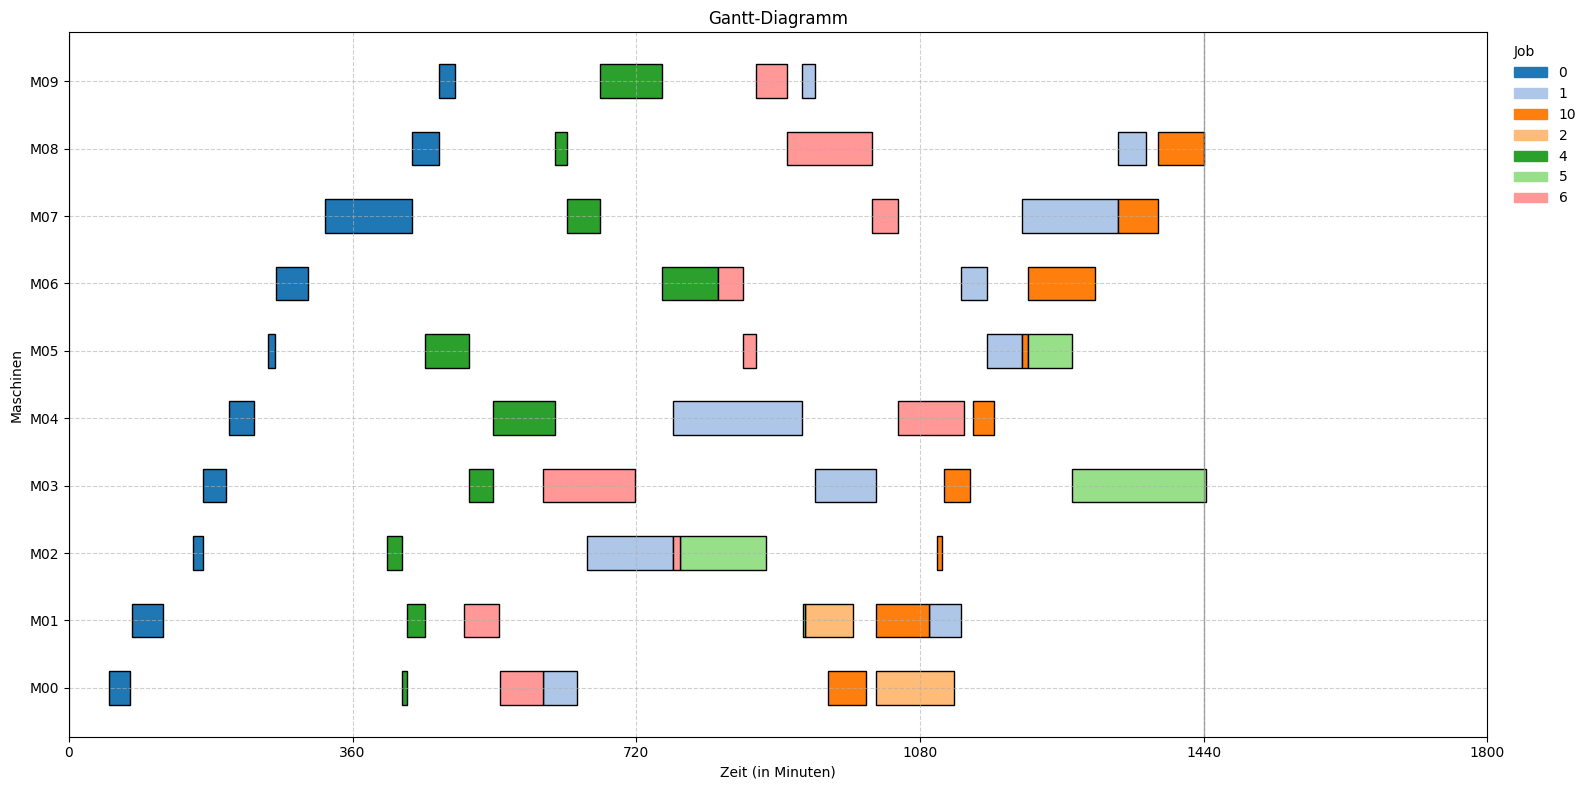

In [15]:
if not df_execution.empty:
    show.plot_gantt(df_execution, perspective="Machine")
else:
    print(f"Nothing executed on day {day_numb}")

In [16]:
df_plan_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
df_plan_undone 

,Job,Production_Plan_ID,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,2,2,2,158,2899.0,M03,1354.0,39.0,1393.0,0
1,10,0,9,963,2869.0,M09,1369.0,21.0,1390.0,0
2,5,5,4,485,2879.0,M08,1369.0,48.0,1417.0,0
3,2,2,3,158,2899.0,M02,1393.0,74.0,1467.0,0
4,5,5,5,485,2879.0,M09,1417.0,72.0,1489.0,0
5,14,4,0,1177,3074.0,M02,1467.0,14.0,1481.0,0
6,2,2,4,158,2899.0,M08,1467.0,90.0,1557.0,0
7,7,7,0,528,3129.0,M02,1481.0,31.0,1512.0,0
...,...,...,...,...,...,...,...,...,...,...
117,12,8,9,992,3873.0,M08,3727.0,74.0,3801.0,0


#### Export

In [17]:
data_path = get_path("data", "lp_tardiness")

In [18]:
df_jssp.to_csv(data_path / "02_tardiness_all_jssp.csv", index = False)
df_job_times.to_csv(data_path / "02_tardiness_all_times.csv", index = False)

In [19]:
df_schedule.to_csv(data_path / "02_tardiness_init_schedule.csv", index = False)
df_execution.to_csv(data_path / "02_tardiness_execution.csv", index = False)
df_plan_undone.to_csv(data_path / "02_tardiness_init_undone.csv", index = False)